In [ ]:
# Install dependencies
!pip install gcsfs openwpm_utils
!pip install tldextract
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.1/770.1 KB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
############### Connect to GCP Bucket ######################
from google.cloud import storage
from google.oauth2 import service_account

client = storage.Client()

project_name = 'level-gizmo-376804'
bucket_name = 'openwpm-bucket'

final_db_1 = '03-23-2023-browse-20-10-10-run-1'
final_db_2 = '03-23-2023-browse-20-10-10-run-2' 

service_account_json = 'level-gizmo-376804-9ec0c24c2d93.json'

credentials = service_account.Credentials.from_service_account_file(service_account_json)
client = storage.Client(project=project_name, credentials=credentials)
bucket = client.get_bucket(bucket_name)

In [ ]:
############### Load Relevant Javascript Measurements ######################
import gcsfs
import json
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# specify table_name
table_name = 'javascript/'

fs = gcsfs.GCSFileSystem(project='level-gizmo-376804',
                         token='level-gizmo-376804-9ec0c24c2d93.json', access="read_write")

url1_js = f'{bucket_name}/{final_db_1}/visits/{table_name}'
data1_js = pq.ParquetDataset(url1_js , use_legacy_dataset=False, filesystem=fs)

js_df1 = data1_js.read_pandas().to_pandas()

In [ ]:
############### Clean JS Measurements ######################
import tldextract
from datetime import date, datetime, timedelta

# Remove first party and blank script url js calls
def strip_1stparty(x):
  url_tldomain = tldextract.extract(x['script_url'])
  top_url_tldomain = tldextract.extract(x['top_level_url'])

  if(top_url_tldomain.domain in url_tldomain.domain):
    return False
  else:
    return True

js_df1_trim = js_df1[js_df1['script_url'] != ""]
mask = js_df1_trim.apply(lambda x: strip_1stparty(x) , axis = 1)
js_df1_trim = js_df1_trim[mask]

# Change VID to Top URL
js_df1_trim[["visit_id"]] = js_df1_trim[["top_level_url"]]

# Clean up timestamps
def timestamp2datetime(tim_stmp):
  tim_stmp = tim_stmp.replace('Z', '')
  try:
    dt = datetime.fromisoformat(tim_stmp)
  except:
    dt = datetime.fromisoformat("5555-12-31T12:59:59.999")
  return dt
js_df1_trim['time_stamp'] = js_df1_trim['time_stamp'].apply(timestamp2datetime)
js_df1_trim = js_df1_trim.sort_values("time_stamp")

# Trim df for listeners
def parse_js_args(arg_str):
  if(type(arg_str) == str):
    if("[" in arg_str):
      arg_str = arg_str.split("[")[1]
      arg_str = arg_str.split("]")[0]
      arg_strs = arg_str.split(",")
      out_list = []
      return arg_strs[0].strip('"')
  return 0
def find_mouse_listeners(df):
  js_calls_of_interest = ["mousemove", "onmousemove", "mousedown", "onmousedown", "mouseup", "onmouseup"]
  df["ArgList"] = df.arguments.apply(lambda x: parse_js_args(x))
  mask = df.ArgList.apply(lambda x: x in js_calls_of_interest)
  return df[mask]
mouse_listeners_1 = find_mouse_listeners(js_df1_trim)

mouse_listeners_1.to_pickle('mouse_listeners_1.pkl')
files.download('mouse_listeners_1.pkl')

display(mouse_listeners_1[["visit_id", "time_stamp", "top_level_url", "script_url", "call_stack", "symbol", "arguments"]])

<ipython-input-6-8fdfa335c3f0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  js_df1_trim[["visit_id"]] = js_df1_trim[["top_level_url"]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,visit_id,time_stamp,top_level_url,script_url,call_stack,symbol,arguments
3006369,https://www.google.com/?gws_rd=ssl,2023-03-24 02:08:39.094,https://www.google.com/?gws_rd=ssl,https://www.gstatic.com/og/_/js/k=og.qtm.en_US...,,EventTarget.addEventListener,"[""mousemove"",""FUNCTION"",false]"
1228049,https://www.bilibili.com/,2023-03-24 02:08:45.369,https://www.bilibili.com/,https://s1.hdslb.com/bfs/static/laputa-home/cl...,,EventTarget.addEventListener,"[""mousedown"",""FUNCTION"",false]"
1228050,https://www.bilibili.com/,2023-03-24 02:08:45.369,https://www.bilibili.com/,https://s1.hdslb.com/bfs/static/laputa-home/cl...,,EventTarget.addEventListener,"[""mouseup"",""FUNCTION"",false]"
2885799,http://www.baidu.com/,2023-03-24 02:08:45.576,http://www.baidu.com/,http://ss.bdimg.com/static/superman/js/lib/jqu...,,EventTarget.addEventListener,"[""mousedown"",""FUNCTION"",false]"
2885859,http://www.baidu.com/,2023-03-24 02:08:45.659,http://www.baidu.com/,http://ss.bdimg.com/static/superman/js/lib/jqu...,,EventTarget.addEventListener,"[""mousedown"",""FUNCTION"",false]"
...,...,...,...,...,...,...,...
2521870,https://www.kooora.com/default.aspx,2023-03-24 11:12:28.364,https://www.kooora.com/default.aspx,https://code.createjs.com/1.0.0/createjs.min.js,,EventTarget.addEventListener,"[""mousemove"",""FUNCTION"",false]"
2521872,https://www.kooora.com/default.aspx,2023-03-24 11:12:28.365,https://www.kooora.com/default.aspx,https://code.createjs.com/1.0.0/createjs.min.js,,HTMLCanvasElement.addEventListener,"[""mousedown"",""FUNCTION"",false]"
1560220,https://www.iconfont.cn/,2023-03-24 11:21:56.988,https://www.iconfont.cn/,https://g.alicdn.com/mm/iconfont-plus-bp/2.51....,,EventTarget.addEventListener,"[""mousemove"",""FUNCTION"",false]"
1560290,https://www.iconfont.cn/,2023-03-24 11:21:59.169,https://www.iconfont.cn/,https://g.alicdn.com/secdev/sufei_data/3.9.10/...,,EventTarget.addEventListener,"[""mousemove"",""FUNCTION"",true]"


In [ ]:
############### Load Relevant HTTP Requests ######################
import gcsfs
import json
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# specify table_name
table_name = 'http_requests/'

url1_http = f'{bucket_name}/{final_db_1}/visits/{table_name}'
data1_http = pq.ParquetDataset(url1_http , use_legacy_dataset=False, filesystem=fs)
df_http_1 = data1_http.read_pandas().to_pandas()

url2_http = f'{bucket_name}/{final_db_2}/visits/{table_name}'
data2_http = pq.ParquetDataset(url2_http , use_legacy_dataset=False, filesystem=fs)
df_http_2 = data2_http.read_pandas().to_pandas()

In [ ]:
############### Load Relevant Cookies ######################
# Note Javascript Cookies is the table with both JS and HTTP cookies!
import gcsfs
import json
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import openwpm_utils.domain as du
import openwpm_utils.analysis as au

# specify table_name
table_name = 'javascript_cookies/'

url_cookies_1 = f'{bucket_name}/{final_db_1}/visits/{table_name}'
url_cookies_2 = f'{bucket_name}/{final_db_2}/visits/{table_name}'

data1_cookies = pq.ParquetDataset(url_cookies_1, use_legacy_dataset=False, filesystem=fs)
data2_cookies = pq.ParquetDataset(url_cookies_2, use_legacy_dataset=False, filesystem=fs)

df_cookies_1 = data1_cookies.read_pandas().to_pandas()
df_cookies_2 = data2_cookies.read_pandas().to_pandas()

In [ ]:
############### Clean Cookie Measurements ######################
import tldextract
from datetime import date, datetime, timedelta

# Change VID to Top URL
top_level_url_dict = {}
url_list = df_http_1["top_level_url"].tolist()
visitid_list = df_http_1["visit_id"].tolist()
for idx in range(len(url_list)):
  top_level_url_dict[visitid_list[idx]] = str(url_list[idx])

df_cookies_1_trim = df_cookies_1.copy()
df_cookies_1_trim['visit_id']= df_cookies_1_trim.visit_id.map(top_level_url_dict)

top_level_url_dict = {}
url_list = df_http_2["top_level_url"].tolist()
visitid_list = df_http_2["visit_id"].tolist()
for idx in range(len(url_list)):
  top_level_url_dict[visitid_list[idx]] = str(url_list[idx])

df_cookies_2_trim = df_cookies_2.copy()
df_cookies_2_trim['visit_id']= df_cookies_2_trim.visit_id.map(top_level_url_dict)

# Remove 1st party cookies
def strip_1stparty_cookies(x):
  url_tldomain = tldextract.extract(x['host'])
  top_url_tldomain = tldextract.extract(x['visit_id'])
  if(top_url_tldomain.domain in url_tldomain.domain):
    return False
  else:
    return True

mask = df_cookies_1_trim.apply(lambda x: strip_1stparty_cookies(x) , axis = 1)
df_cookies_1_trim = df_cookies_1_trim[mask]
mask = df_cookies_2_trim.apply(lambda x: strip_1stparty_cookies(x) , axis = 1)
df_cookies_2_trim = df_cookies_2_trim[mask]

# Clean up timestamps
def timestamp2datetime(tim_stmp):
  tim_stmp = tim_stmp.replace('Z', '')
  try:
    dt = datetime.fromisoformat(tim_stmp)
  except:
    dt = datetime.fromisoformat("5555-12-31T12:59:59.999")
  return dt

df_cookies_1_trim['time_stamp'] = df_cookies_1_trim['time_stamp'].apply(timestamp2datetime)
df_cookies_1_trim = df_cookies_1_trim.sort_values("time_stamp")
df_cookies_2_trim['time_stamp'] = df_cookies_2_trim['time_stamp'].apply(timestamp2datetime)
df_cookies_2_trim = df_cookies_2_trim.sort_values("time_stamp")

df_cookies_1_trim.to_pickle('df_cookies_1_trim.pkl')
files.download('df_cookies_1_trim.pkl')
df_cookies_1_trim.to_pickle('df_cookies_2_trim.pkl')
files.download('df_cookies_2_trim.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
############### Clean HTTP/HTTPS Measurements ######################
# Remove 1st party HTTP requests
import tldextract
from datetime import date, datetime, timedelta

def strip_1stparty_http(x):
  url_tldomain = tldextract.extract(x['url'])
  top_url_tldomain = tldextract.extract(x['top_level_url'])

  if(top_url_tldomain.domain in url_tldomain.domain):
    return False
  else:
    return True

mask = df_http_1.apply(lambda x: strip_1stparty_http(x) , axis = 1)
df_http_1_trim = df_http_1[mask]

# Clean up timestamps
def timestamp2datetime(tim_stmp):
  tim_stmp = tim_stmp.replace('Z', '')
  try:
    dt = datetime.fromisoformat(tim_stmp)
  except:
    dt = datetime.fromisoformat("5555-12-31T12:59:59.999")
  return dt

df_http_1_trim['time_stamp'] = df_http_1_trim['time_stamp'].apply(timestamp2datetime)

# Change VID to Top URL
df_http_1_trim[["visit_id"]] = df_http_1_trim[["top_level_url"]]
df_http_1_trim = df_http_1_trim.sort_values("time_stamp")
df_http_1_trim.to_pickle('df_http_1_trim.pkl')
files.download('df_http_1_trim.pkl')

<ipython-input-10-aa532e2e9e12>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_1_trim['time_stamp'] = df_http_1_trim['time_stamp'].apply(timestamp2datetime)
<ipython-input-10-aa532e2e9e12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_1_trim[["visit_id"]] = df_http_1_trim[["top_level_url"]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
############### Capture and Save DataFrame Metrics ######################
db_info = {
    "HTTP_HTTPS_raw": df_http_1.info(),
    "HTTP_HTTPS_trimmed":  df_http_1_trim.info(),
    "JS_raw": js_df1.info(),
    "mouse_listeners_1": mouse_listeners_1.info(),
    "Cookies_raw" : df_cookies_1.info(),
    "Cookies_trimmed" : df_cookies_1_trim.info()
}



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210341 entries, 0 to 210340
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   incognito                     210341 non-null  int32  
 1   browser_id                    210341 non-null  int64  
 2   visit_id                      210341 non-null  int64  
 3   instance_id                   210341 non-null  int64  
 4   extension_session_uuid        210341 non-null  object 
 5   event_ordinal                 210341 non-null  int64  
 6   window_id                     205182 non-null  float64
 7   tab_id                        210341 non-null  int64  
 8   frame_id                      210341 non-null  int64  
 9   url                           210341 non-null  object 
 10  top_level_url                 210341 non-null  object 
 11  parent_frame_id               210341 non-null  int64  
 12  frame_ancestors               210341 non-nul

In [ ]:
############### 1st Pass - Intentify Tracker Cookie Candidates ###############
from difflib import SequenceMatcher
from datetime import date, datetime, timedelta
import string
import time
import warnings
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

dynamic_delta_time = timedelta(seconds = 31)

def days_delta(dt1, dt0):
  if(dt1 > pd.Timestamp.max):
    dt1 = pd.Timestamp.max
  if(dt0 > pd.Timestamp.max):
    dt0 = pd.Timestamp.max
  dt_delta = dt1-dt0
  return dt_delta.days

def find_delim(param_tuples, valid_val_delims):
    # Initialize list of potential delimiters
    pot_delims = []
    val_char_list = list(param_tuples[0][1])
    # Determine the delimiter candidate from first tuple
    if val_char_list != '':
      for pot_delim in val_char_list:
          # Cadidate is the first valid delim character in the string
          if pot_delim:
              if pot_delim in valid_val_delims:
                  pot_delims.append(pot_delim)
                  break
      if len(set(pot_delims)) > 1 or pot_delims == []:
          return 0
      else:
          return pot_delims[0]
    else:
      return 0
        
def gen_params(val, cookie_name, name_delim, valid_val_delims):
        params_temp = []
        cookie_tupls = []
        valid_val_delims.remove(name_delim)
        valid_val_delims.remove('\t')
        valid_val_delims.remove("\n")
        valid_val_delims.remove("\r")
        valid_val_delims.remove("\x0b")
        valid_val_delims.remove("\x0c")
        split_params = val.split(name_delim)
        # If one or fewer (param_name, param_val) pair ignore sub_val params
        if(len(split_params)< 2):
            return [(cookie_name, "no_params_found", val)]
        # Split param_name, param_value candidates
        for idx in range(len(split_params)-2):
            # Construct list of tuples
            params_temp.append((split_params[idx], split_params[idx+1]))
        val_name_delim = 0
        if params_temp != []:
          val_name_delim = find_delim(params_temp, valid_val_delims)
        if val_name_delim == 0:
            return [(cookie_name, "no_params_found", val)]
        else:
            for ptup in params_temp:
                param_name = val_name_delim.join(ptup[0].split(val_name_delim)[1:])
                # Handle first name
                if(param_name == ''):
                    param_name = val_name_delim.join(ptup[0].split(val_name_delim)[0:])
                param_val = val_name_delim.join(ptup[1].split(val_name_delim)[0:1])
                cookie_tupls.append((cookie_name, param_name, param_val))
        return cookie_tupls

def parse_params(cookie_value, cookie_name, name_delim):
    # Which characters are allowed in val
    valid_val_chars = list(string.ascii_uppercase) + list(string.ascii_lowercase) \
                      + [str(x) for x in list(range(10))] + ["_", "-"]
    # Which characters are allowed in val delims
    valid_val_delims = [item for item in string.printable if item not in valid_val_chars]
    return(gen_params(cookie_value, cookie_name, name_delim, valid_val_delims))

def get_tracker_per_crawl(df_analys_cookies):
  df_analys_cookies['expiry'] = df_analys_cookies['expiry'].apply(timestamp2datetime)
  # Calculate delta of expiration date in days
  df_analys_cookies['expiry_delta'] = df_analys_cookies.apply(lambda x: \
    days_delta(x['expiry'], x['time_stamp']), axis=1)
  df_analys_cookies['cookie_param_tuples'] = df_analys_cookies.apply(lambda x: \
    parse_params(x['value'], x['name'], "="), axis=1)

  # Modifying slightly from paper as this would be an easy way to thwart
  #   detecting cookie trackers.
  df_analys_cookies = df_analys_cookies[df_analys_cookies['expiry_delta'] > 88]

  df_analys_cookies = df_analys_cookies[df_analys_cookies['is_session'] == False]
  df_analys_cookies = df_analys_cookies[df_analys_cookies['same_site'] == 'no_restriction']

  # Dict is updated for each cookie on a visit
  cookie_dict_out = {
    "hosts" : [],
    "visit_id" : [],
    "start_static_time" : [],
    "start_dynamic_time" : [],
    "cookie_name" : [],
    "param_names" : [],
    "browser_id" : [],
    "instance_id" : [],
    "param_val_static" : [],
    "num_static_events" : [],
    "num_dynamic_events" : []
  }

  # Instance ID -> Browser ID -> Visit ID -> Cookie Name -> Host -> Parameters
  #   Parameters are analyzed  for a particular cookie sorted in time,
  #   if the cookie parameter changes in the static period it is not considered
  #   a tracking cookie. Also, if it has an exipry delta greater than 89, also if
  #   between two concurrently running crawls two identical visits yield nearly
  #   identical parameter values.
  #
  # Other notes: a single parameter cookie is not disaggregated into multiple parts
  #   No need, because if anything in the cookie string changes it is not a tracker
  for instance_id in df_analys_cookies['instance_id'].unique():
    # Get sub df for the instance
    sub_1_df = df_analys_cookies[df_analys_cookies['instance_id'] == instance_id]
    for browserid in sub_1_df['browser_id'].unique():
        # Get sub df for the browser
        sub_2_df = sub_1_df[sub_1_df['browser_id']==browserid]
        for visid in sub_2_df['visit_id'].unique():
          # Get sub df for the visit
          sub_3_df = sub_2_df[sub_2_df['visit_id'] == visid]
          for cookie_name in sub_3_df['name'].unique():
            # Get sub df for this cookie
            sub_4_df = sub_3_df[sub_3_df['name'] == cookie_name]
            sub_4_df = sub_4_df.sort_values('time_stamp')
            static_cookie_time = min(sub_4_df["time_stamp"].tolist())
            dynamic_cookie_time = static_cookie_time + dynamic_delta_time 
            static_cookie_df = sub_4_df[sub_4_df["time_stamp"] \
                                        > static_cookie_time]
            static_cookie_df = sub_4_df[sub_4_df["time_stamp"] \
                                        <= dynamic_cookie_time]
            dynamic_cookie_df = sub_4_df[sub_4_df["time_stamp"] \
                                        > dynamic_cookie_time]
            num_static_events = len(static_cookie_df.index)
            if num_static_events == []:
              num_static_events = 0
            num_dynamic_events = len(dynamic_cookie_df.index)
            if num_dynamic_events == []:
              num_dynamic_events = 0
            # Construct a new small df for this cookie using a dict
            cookie_dict_tmp = {
              "param_names" : [],
              "param_vals" : [],
              "time_stamp" : [],
              "host" : [],
              "path" : []
            }
            # Expand the cookie parameter tuples into the df for this cookie
            for idx, cookie_param_tupls in enumerate(sub_4_df['cookie_param_tuples']):
              for tupl in cookie_param_tupls:
                cookie_dict_tmp['path'].append(sub_4_df['path'].tolist()[idx])
                cookie_dict_tmp['param_names'].append(tupl[1])
                cookie_dict_tmp['param_vals'].append(tupl[2])
                cookie_dict_tmp['time_stamp'].append(sub_4_df['time_stamp'].tolist()[idx])
                cookie_dict_tmp['host'].append(sub_4_df['host'].tolist()[idx])
            cookie_df = pd.DataFrame(cookie_dict_tmp)
            # Many parameters may be overwritten to the same value, to avoid
            #   duplicate counts, only look at the time series of unique cookie params
            for param_name in cookie_df["param_names"].unique():
              # Otherwise paartition static and dynamic periods to check event counts
              this_cookie_param_df = cookie_df[cookie_df["param_names"] == param_name]
              static_cookie_time = min(this_cookie_param_df["time_stamp"].tolist())
              dynamic_cookie_time = static_cookie_time + dynamic_delta_time 
              static_cookie_df = this_cookie_param_df[this_cookie_param_df["time_stamp"] \
                                          > static_cookie_time]
              static_cookie_df = this_cookie_param_df[this_cookie_param_df["time_stamp"] \
                                          <= dynamic_cookie_time]
              dynamic_cookie_df = this_cookie_param_df[this_cookie_param_df["time_stamp"] \
                                          > dynamic_cookie_time]
              static_cookie_df = static_cookie_df.sort_values("time_stamp")
              if(len(static_cookie_df["param_vals"].unique().tolist()) == 1):
                # Document as a tracker - means expiration > 89 days, and params are consistent
                cookie_dict_out["hosts"].append(static_cookie_df["host"].tolist()[0])
                cookie_dict_out["start_static_time"].append(static_cookie_time)
                cookie_dict_out["start_dynamic_time"].append(dynamic_cookie_time)
                cookie_dict_out["instance_id"].append(instance_id)
                cookie_dict_out["visit_id"].append(visid)
                cookie_dict_out["browser_id"].append(browserid)
                cookie_dict_out["cookie_name"].append(cookie_name)
                cookie_dict_out["param_names"].append(param_name)
                cookie_dict_out["param_val_static"].append(static_cookie_df["param_vals"].tolist()[0])
                cookie_dict_out["num_static_events"].append(num_static_events)
                cookie_dict_out["num_dynamic_events"].append(num_dynamic_events)
  cookie_out_df = pd.DataFrame(cookie_dict_out)
  return(cookie_out_df.sort_values("start_static_time"))

# Identify cookie candidates
cookie_candidate_df1 = get_tracker_per_crawl(df_cookies_1_trim)

# Identify cookie candidates
cookie_candidate_df2 = get_tracker_per_crawl(df_cookies_2_trim)

In [ ]:
############### 2nd Pass - Intentify Tracker Cookies ###############
# Given two sets of cookie candidates, identify which are present in both datasets
cookie_dict_out = {
    "hosts" : [],
    "visit_id" : [],
    "start_static_time_run_1" : [],
    "start_static_time_run_2" : [],
    "start_dynamic_time_run_1" : [],
    "start_dynamic_time_run_2" : [],
    "cookie_name" : [],
    "param_names" : [],
    "param_val_run_1" : [],
    "param_val_run_2" : [],
    "gestalt" : [],
    "num_static_events" : [],
    "num_dynamic_events" : []
}

# Calculate Gestalt for cookie param values of two runs
#   if Gestalt is possible, populate cookie param into final Cookie df
for idx, visit_id in enumerate(cookie_candidate_df1["visit_id"].unique().tolist()):
  sub_df_1_1 = cookie_candidate_df1[cookie_candidate_df1["visit_id"] == visit_id]
  sub_df_1_2 = cookie_candidate_df2[cookie_candidate_df2["visit_id"] == visit_id]
  for host in sub_df_1_1["hosts"].unique():
    sub_df_2_1 = sub_df_1_1[sub_df_1_1["hosts"] == host]
    sub_df_2_2 = sub_df_1_2[sub_df_1_2["hosts"] == host]
    for cookie_name in sub_df_2_1["cookie_name"].tolist():
      sub_df_3_1 = sub_df_2_1[sub_df_2_1["cookie_name"] == cookie_name]
      sub_df_3_2 = sub_df_2_2[sub_df_2_2["cookie_name"] == cookie_name]
      for param_name in sub_df_3_1["param_names"].tolist():
        sub_df_4_1 = sub_df_3_1[sub_df_3_1["param_names"] == param_name]
        sub_df_4_2 = sub_df_3_2[sub_df_3_2["param_names"] == param_name]
        # Skip if cookie already tagged as tracker
        if( len(sub_df_4_1["param_val_static"].tolist()) == 1 and len(sub_df_4_2["param_val_static"].tolist()) == 1):
          param1 = str(sub_df_4_1["param_val_static"].tolist()[0])
          # display(param1)
          param2 = str(sub_df_4_2["param_val_static"].tolist()[0])
          # display(param2)
          # Check if they are equal to save compute overhead Gestalt is slooooow
          if(param1 != param2):
            gestalt = SequenceMatcher(None, param1, param2)
            gestalt.get_matching_blocks()
            gestalt.get_opcodes()
            gestalt = gestalt.ratio()
            # display(gestalt)
            # time.sleep(1)
            # Add to final tracking cookie df if it passses the Gestalt test
            if(gestalt < 0.66):
              cookie_dict_out["hosts"].append(host)
              cookie_dict_out["visit_id"].append(visit_id)
              cookie_dict_out["start_static_time_run_1"].append(sub_df_4_1["start_static_time"].tolist()[0])
              cookie_dict_out["start_static_time_run_2"].append(sub_df_4_2["start_static_time"].tolist()[0])
              cookie_dict_out["start_dynamic_time_run_1"].append(sub_df_4_1["start_dynamic_time"].tolist()[0])
              cookie_dict_out["start_dynamic_time_run_2"].append(sub_df_4_2["start_dynamic_time"].tolist()[0])
              cookie_dict_out["cookie_name"].append(cookie_name)
              cookie_dict_out["param_names"].append(param_name)
              cookie_dict_out["param_val_run_1"].append(param1)
              cookie_dict_out["param_val_run_2"].append(param2)
              cookie_dict_out["gestalt"].append(gestalt)
              cookie_dict_out["num_dynamic_events"].append(sub_df_4_1["num_dynamic_events"].tolist()[0])
              cookie_dict_out["num_static_events"].append(sub_df_4_1["num_static_events"].tolist()[0])
              break

tracker_cookies = pd.DataFrame(cookie_dict_out)
display(tracker_cookies)

,hosts,visit_id,start_static_time_run_1,start_static_time_run_2,start_dynamic_time_run_1,start_dynamic_time_run_2,cookie_name,param_names,param_val_run_1,param_val_run_2,gestalt,num_static_events,num_dynamic_events
0,accounts.google.com,https://www.youtube.com/,2023-03-24 02:08:40.379,2023-03-24 02:08:52.784,2023-03-24 02:09:11.379,2023-03-24 02:09:23.784,__Host-GAPS,no_params_found,1:C4DorPy-1o7nprlKjzcos3uuTGORQg:oYXidFIdki0NhrGS,1:Bl_-VkR_6dAeb_pz-IhPQprx5Ona:lyIFkbGNgJ9G5FSA,0.208333,1,0
1,.google.com,https://www.youtube.com/,2023-03-24 02:08:47.174,2023-03-24 02:09:01.006,2023-03-24 02:09:18.174,2023-03-24 02:09:32.006,NID,no_params_found,511=hniCFfQQz1772NmILZsP-MKy7BEm9AWHaAn4m81TOe...,511=bqygurEK1xbogYU9CyA2I1z_9tUDUY1ZDiIVb4wPWc...,0.142857,1,0
2,.hm.baidu.com,https://www.zhihu.com/signin?next=%2F,2023-03-24 02:10:14.879,2023-03-24 02:10:23.487,2023-03-24 02:10:45.879,2023-03-24 02:10:54.487,HMACCOUNT,no_params_found,F087BC35DD720444,355DF819628A4FD5,0.250000,1,0
3,.demdex.net,https://www.linkedin.com/,2023-03-24 02:11:31.063,2023-03-24 02:12:17.581,2023-03-24 02:12:02.063,2023-03-24 02:12:48.581,demdex,no_params_found,13890389695616324621945809569368101812,17745850867997280202100564594697066801,0.342105,3,0
4,.doubleclick.net,https://www.linkedin.com/,2023-03-24 02:11:32.069,2023-03-24 02:12:18.977,2023-03-24 02:12:03.069,2023-03-24 02:12:49.977,IDE,no_params_found,AHWqTUl8-kzDZh-vplXatKQyDHq4Rc_JTffzQhbq2iSJZ2...,AHWqTUnkiDIAnkimYD5FWG9Tq7r9F_WymTR0oU_sdKwh6R...,0.208955,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,.twitter.com,https://www.hostinger.in/,2023-03-24 11:11:24.071,2023-03-24 11:15:26.299,2023-03-24 11:11:55.071,2023-03-24 11:15:57.299,personalization_id,no_params_found,"""v1_UR3KEYCs7iXUGjjWMg+nyg==""","""v1_h3JO9rg3xLG+d8cWOaIjqg==""",0.379310,1,0
4994,.t.co,https://www.hostinger.in/,2023-03-24 11:11:24.072,2023-03-24 11:15:26.300,2023-03-24 11:11:55.072,2023-03-24 11:15:57.300,muc_ads,no_params_found,3eb3cb8b-3c36-4223-bde3-4373770204c7,5f328d2e-da19-481b-8da3-d3578263ab88,0.166667,1,0
4995,.linkedin.com,https://www.hostinger.in/,2023-03-24 11:11:24.867,2023-03-24 11:15:26.002,2023-03-24 11:11:55.867,2023-03-24 11:15:57.002,li_sugr,no_params_found,287053e0-cbd0-4ac4-98cf-4009da4bd331,8d47019b-3dbf-4b4a-bc54-550ee930bb72,0.305556,5,0
4996,.linkedin.com,https://www.hostinger.in/,2023-03-24 11:11:24.868,2023-03-24 11:15:26.003,2023-03-24 11:11:55.868,2023-03-24 11:15:57.003,bcookie,no_params_found,"""v=2&4d689ace-228b-47dc-8dff-4fc7c722cdb2""","""v=2&a69e7177-0c4e-4900-8921-d83b400612eb""",0.261905,5,0


In [ ]:
############### Capture HTTP Traffic After Tracker Cookie is Issued ###############
from difflib import SequenceMatcher
import string
import time
import warnings
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import tldextract
from datetime import date, datetime, timedelta

def check_url(js_url, cookie_domain):
  url_js_tldomain = tldextract.extract(js_url)
  url_cookie_tldomain = tldextract.extract(cookie_domain)
  if(url_js_tldomain.domain == url_cookie_tldomain.domain):
    return True
  else:
    return False

# Copy HTTP requests
df1_js = mouse_listeners_1

tracker_cookies_cpy = tracker_cookies.copy()

display(tracker_cookies_cpy)

js_dict = {
    "visit_id" : [],
    "tracker_url" : []
}

dynamic_time = timedelta(seconds = 10)
# Get JS mouse timeframe traffic at visit location during the lifetime of each tracker cookie
for visit_id in tracker_cookies_cpy["visit_id"].unique().tolist():
  tracker_cookies_sub_1 = tracker_cookies_cpy[tracker_cookies_cpy["visit_id"] == visit_id]
  df1_js_sub_1 = df1_js[df1_js["top_level_url"] == visit_id]
  script_url_domains = []
  for script_url in df1_js_sub_1["script_url"]:
    script_url_domains.append(tldextract.extract(script_url).domain)
  for host in tracker_cookies_sub_1["hosts"].unique().tolist():
    if(tldextract.extract(host).domain in script_url_domains):
        js_dict["visit_id"].append(visit_id)
        js_dict["tracker_url"].append(host)

js_cookies = pd.DataFrame(js_dict)
display(js_cookies)

,hosts,visit_id,start_static_time_run_1,start_static_time_run_2,start_dynamic_time_run_1,start_dynamic_time_run_2,cookie_name,param_names,param_val_run_1,param_val_run_2,gestalt,num_static_events,num_dynamic_events
0,accounts.google.com,https://www.youtube.com/,2023-03-24 02:08:40.379,2023-03-24 02:08:52.784,2023-03-24 02:09:11.379,2023-03-24 02:09:23.784,__Host-GAPS,no_params_found,1:C4DorPy-1o7nprlKjzcos3uuTGORQg:oYXidFIdki0NhrGS,1:Bl_-VkR_6dAeb_pz-IhPQprx5Ona:lyIFkbGNgJ9G5FSA,0.208333,1,0
1,.google.com,https://www.youtube.com/,2023-03-24 02:08:47.174,2023-03-24 02:09:01.006,2023-03-24 02:09:18.174,2023-03-24 02:09:32.006,NID,no_params_found,511=hniCFfQQz1772NmILZsP-MKy7BEm9AWHaAn4m81TOe...,511=bqygurEK1xbogYU9CyA2I1z_9tUDUY1ZDiIVb4wPWc...,0.142857,1,0
2,.hm.baidu.com,https://www.zhihu.com/signin?next=%2F,2023-03-24 02:10:14.879,2023-03-24 02:10:23.487,2023-03-24 02:10:45.879,2023-03-24 02:10:54.487,HMACCOUNT,no_params_found,F087BC35DD720444,355DF819628A4FD5,0.250000,1,0
3,.demdex.net,https://www.linkedin.com/,2023-03-24 02:11:31.063,2023-03-24 02:12:17.581,2023-03-24 02:12:02.063,2023-03-24 02:12:48.581,demdex,no_params_found,13890389695616324621945809569368101812,17745850867997280202100564594697066801,0.342105,3,0
4,.doubleclick.net,https://www.linkedin.com/,2023-03-24 02:11:32.069,2023-03-24 02:12:18.977,2023-03-24 02:12:03.069,2023-03-24 02:12:49.977,IDE,no_params_found,AHWqTUl8-kzDZh-vplXatKQyDHq4Rc_JTffzQhbq2iSJZ2...,AHWqTUnkiDIAnkimYD5FWG9Tq7r9F_WymTR0oU_sdKwh6R...,0.208955,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,.twitter.com,https://www.hostinger.in/,2023-03-24 11:11:24.071,2023-03-24 11:15:26.299,2023-03-24 11:11:55.071,2023-03-24 11:15:57.299,personalization_id,no_params_found,"""v1_UR3KEYCs7iXUGjjWMg+nyg==""","""v1_h3JO9rg3xLG+d8cWOaIjqg==""",0.379310,1,0
4994,.t.co,https://www.hostinger.in/,2023-03-24 11:11:24.072,2023-03-24 11:15:26.300,2023-03-24 11:11:55.072,2023-03-24 11:15:57.300,muc_ads,no_params_found,3eb3cb8b-3c36-4223-bde3-4373770204c7,5f328d2e-da19-481b-8da3-d3578263ab88,0.166667,1,0
4995,.linkedin.com,https://www.hostinger.in/,2023-03-24 11:11:24.867,2023-03-24 11:15:26.002,2023-03-24 11:11:55.867,2023-03-24 11:15:57.002,li_sugr,no_params_found,287053e0-cbd0-4ac4-98cf-4009da4bd331,8d47019b-3dbf-4b4a-bc54-550ee930bb72,0.305556,5,0
4996,.linkedin.com,https://www.hostinger.in/,2023-03-24 11:11:24.868,2023-03-24 11:15:26.003,2023-03-24 11:11:55.868,2023-03-24 11:15:57.003,bcookie,no_params_found,"""v=2&4d689ace-228b-47dc-8dff-4fc7c722cdb2""","""v=2&a69e7177-0c4e-4900-8921-d83b400612eb""",0.261905,5,0


,visit_id,tracker_url
0,https://www.youtube.com/,accounts.google.com
1,https://www.youtube.com/,.google.com
2,https://world.taobao.com/,g.alicdn.com
3,https://dzen.ru/?yredirect=true,.mail.ru
4,https://www.csdn.net/,.hm.baidu.com
...,...,...
167,https://habr.com/en/all/,.yandex.com
168,https://www.cnet.com/,.ad.gt
169,https://report.az/,.youtube.com
170,https://report.az/,.yandex.com


In [ ]:
from difflib import SequenceMatcher
from datetime import date, datetime, timedelta
import tldextract
import string
import time
import warnings
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Copy HTTP requests
df1_http = df_http_1_trim
tracker_cookies_cpy = tracker_cookies.drop_duplicates()

http_request_dict = {
    "hosts" : [],
    "visit_id" : [],
    "cookie_name" : [],
    "total_requests" : [],
    "static_requests" : [],
    "dynamic_requests" : [],
}

dynamic_time = timedelta(seconds = 10)
# Get HTTP traffic at visit location during the lifetime of each tracker cookie
for visit_id in tracker_cookies_cpy["visit_id"].unique().tolist():
  tracker_cookies_sub_1 = tracker_cookies_cpy[tracker_cookies_cpy["visit_id"] == visit_id]
  df1_http_sub_1 = df1_http[df1_http["top_level_url"] == visit_id]
  for host in tracker_cookies_sub_1["hosts"].unique().tolist():
    host_domain = tldextract.extract(host).domain
    mask = df1_http_sub_1["url"].apply(lambda x: tldextract.extract(x).domain == host_domain)
    df1_http_sub_2 = df1_http_sub_1[mask]
    if(len(df1_http_sub_2.index) > 0):
      for cookie_name in tracker_cookies_sub_1["cookie_name"].unique().tolist():
        tracker_cookies_sub_3 = tracker_cookies_sub_1[tracker_cookies_sub_1["cookie_name"] == cookie_name]
        # Now that we have selected a cookie param get it's time window
        start_time = min(tracker_cookies_sub_3["start_static_time_run_1"].tolist())
        end_static_time = max(tracker_cookies_sub_3["start_dynamic_time_run_1"].tolist())
        end_time = max(tracker_cookies_sub_3["start_dynamic_time_run_1"].tolist()) + dynamic_time
        # display(host_regex)
        # display(visit_id_regex)
        # time.sleep(.2)
        # Get HTTP traffic in the total timeframe to the cookie host
        df1_http_sub_3 = df1_http_sub_2[df1_http_sub_2["time_stamp"] >= start_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["time_stamp"] <= end_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["top_level_url"] == visit_id]
        total_requests = len(df1_http_sub_3.index)
        # Get HTTP traffic in the static timeframe to the cookie host 
        df1_http_sub_3 = df1_http_sub_2[df1_http_sub_2["time_stamp"] >= start_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["time_stamp"] <= end_static_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["top_level_url"] == visit_id]
        static_requests = len(df1_http_sub_3.index)
        # Get HTTP traffic in the dynamic timeframe to the cookie host 
        df1_http_sub_3 = df1_http_sub_2[df1_http_sub_2["time_stamp"] > end_static_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["time_stamp"] <= end_time]
        df1_http_sub_3 = df1_http_sub_3[df1_http_sub_3["top_level_url"] == visit_id]
        dynamic_requests = len(df1_http_sub_3.index)
        if(total_requests > 1):
          http_request_dict["hosts"].append(host)
          http_request_dict["visit_id"].append(visit_id)
          http_request_dict["cookie_name"].append(cookie_name)
          http_request_dict["total_requests"].append(total_requests)
          http_request_dict["static_requests"].append(static_requests)
          http_request_dict["dynamic_requests"].append(dynamic_requests)

http_request_cookies = pd.DataFrame(http_request_dict)
display(http_request_cookies)

,hosts,visit_id,cookie_name,total_requests,static_requests,dynamic_requests
0,accounts.google.com,https://www.youtube.com/,__Host-GAPS,5,5,0
1,accounts.google.com,https://www.youtube.com/,NID,3,1,2
2,.google.com,https://www.youtube.com/,__Host-GAPS,5,5,0
3,.google.com,https://www.youtube.com/,NID,3,1,2
4,.demdex.net,https://www.linkedin.com/,demdex,4,4,0
...,...,...,...,...,...,...
39016,.linkedin.com,https://www.hostinger.in/,_pinterest_ct_ua,2,2,0
39017,.ct.pinterest.com,https://www.hostinger.in/,personalization_id,5,5,0
39018,.ct.pinterest.com,https://www.hostinger.in/,muc_ads,5,5,0
39019,.ct.pinterest.com,https://www.hostinger.in/,li_sugr,5,5,0


,site_name,hosts3p,traffic3p,tracker3p_count
309,https://www.futbin.com/,"[.imrworldwide.com, .exelator.com, .openx.net,...",20330,34
254,https://www.javatpoint.com/,"[.adpushup.com, .crwdcntrl.net, .adsrvr.org, ....",11856,38
98,https://www.forbes.com/,"[.media.net, .openx.net, .adnxs.com, .adsrvr.o...",10597,33
232,https://www.businessinsider.com/,"[.taboola.com, .linkedin.com, .ml314.com, .ads...",10484,36
87,https://9gag.com/,"[.adnxs.com, .rubiconproject.com, .openx.net, ...",9554,28
...,...,...,...,...
42,https://gitee.com/,[.hm.baidu.com],2,1
70,https://www.runoob.com/,[.hm.baidu.com],2,1
63,https://www.ixigua.com/?wid_try=1,[.bytedance.com],2,1
48,https://www.binance.com/en,[.bing.com],2,1


'Unique sites with third party trackers: 343'

'Unique sites with third party mouse trackers: 114'

,num_trackers,mouse_sites
113,3,https://report.az/
64,3,https://ria.ru/
12,3,https://www.alibaba.com/
88,3,https://www.lowes.com/
77,2,https://www.indiamart.com/
...,...,...
49,1,https://www.423down.com/
48,1,http://wnacg.org/
47,1,https://itch.io/
46,1,https://www.merriam-webster.com/


,site_name,hosts3p
0,https://www.youtube.com/,accounts.google.com
1,https://www.youtube.com/,.google.com
2,https://world.taobao.com/,g.alicdn.com
3,https://dzen.ru/?yredirect=true,.mail.ru
4,https://www.csdn.net/,.hm.baidu.com
...,...,...
137,https://habr.com/en/all/,.yandex.com
138,https://www.cnet.com/,.ad.gt
139,https://report.az/,.youtube.com
140,https://report.az/,.yandex.com


,num_trackers,mouse_sites
6,22,.yandex.com
4,19,.hm.baidu.com
10,19,www.clarity.ms
3,7,.mail.ru
16,6,.youtube.com
18,6,.ml314.com
1,5,.google.com
28,4,.yandex.ru
5,4,.ad.gt
8,4,.chaturbate.com


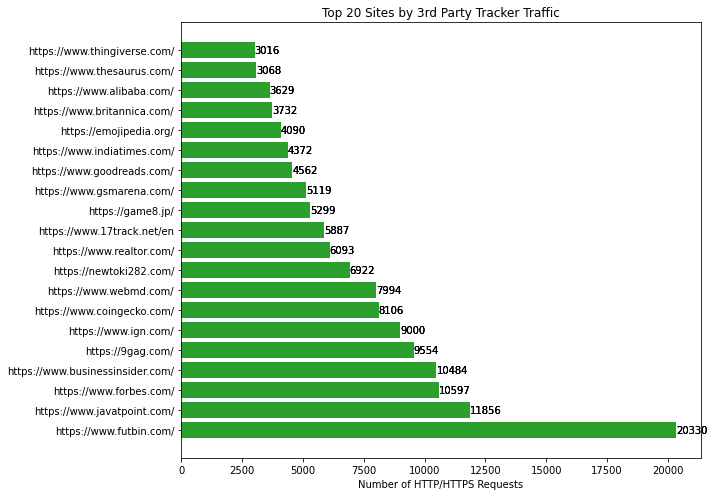

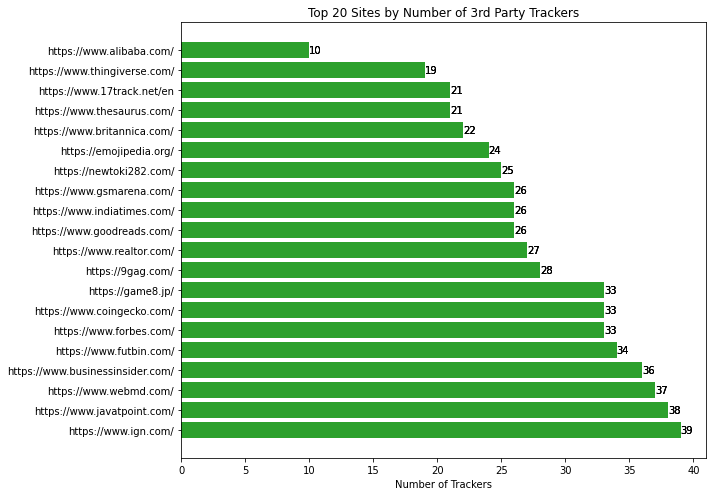

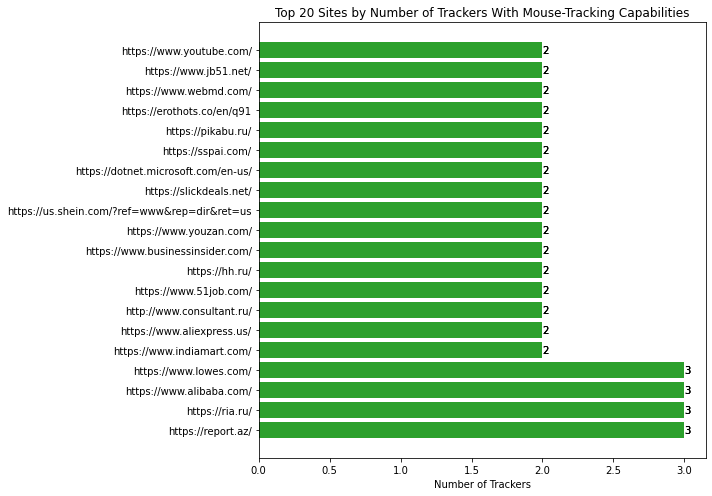

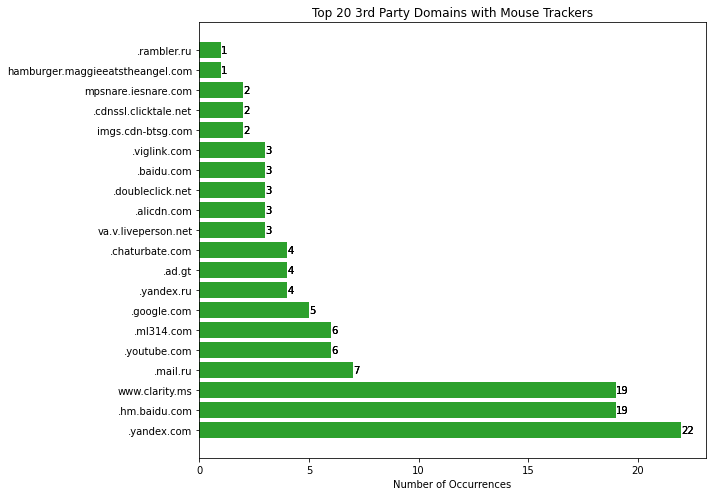

In [ ]:
from difflib import SequenceMatcher
from datetime import date, datetime, timedelta
import tldextract
import string
import time
import warnings
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Collect data

site_traffic_dict = {
    "site_name" : [],
    "hosts3p" : [],
    "traffic3p" : []
}

for site in http_request_cookies['visit_id'].unique():
  http_3preq_this_site = http_request_cookies[http_request_cookies['visit_id'] == site]
  site_traffic_dict["site_name"].append(site)
  site_traffic_dict["traffic3p"].append(sum(http_3preq_this_site["total_requests"].tolist()))
  site_traffic_dict["hosts3p"].append(http_3preq_this_site["hosts"].unique().tolist())

tracker_site_reqs_3p = pd.DataFrame(site_traffic_dict)
tracker_site_reqs_3p = tracker_site_reqs_3p.sort_values("traffic3p", ascending=False)
tracker_site_reqs_3p["tracker3p_count"] = tracker_site_reqs_3p["hosts3p"].apply(lambda x: len(x))
display(tracker_site_reqs_3p)

num_sites = len(tracker_site_reqs_3p["site_name"].unique().tolist())
display(f"Unique sites with third party trackers: {num_sites}")

# Plot top 20 sites by volume of HTTP traffic
fig, ax = plt.subplots(figsize =(10, 7))
plot_top_tracker_sites = tracker_site_reqs_3p.head(20)
site_names = plot_top_tracker_sites["site_name"].tolist()
http3p = plot_top_tracker_sites["traffic3p"].tolist()
plt.barh(site_names, http3p)
bars = ax.barh(site_names, http3p)
ax.barh(site_names, http3p)
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_title("Top 20 Sites by 3rd Party Tracker Traffic")
ax.set_xlabel("Number of HTTP/HTTPS Requests")
plt.tight_layout()
plt.savefig('plot_top_20_http_traffic.png', dpi=400)

# Plot top 20 sites by number of trackers
fig, ax = plt.subplots(figsize =(10, 7))
plot_top_tracker_sites = tracker_site_reqs_3p.head(20)
sort_tracker_3p = plot_top_tracker_sites.sort_values("tracker3p_count", ascending=False)
site_names = sort_tracker_3p ["site_name"].tolist()
num3p = sort_tracker_3p ["tracker3p_count"].tolist()
plt.barh(site_names, num3p)
bars = ax.barh(site_names, num3p)
ax.barh(site_names, num3p)
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_title("Top 20 Sites by Number of 3rd Party Trackers")
ax.set_xlabel("Number of Trackers")
plt.tight_layout()
plt.savefig('num_trackers.png', dpi=400)

site_traffic_mouse_dict = {
    "site_name" : [],
    "hosts3p" : []
}

# Number of requests to 3p trackers with mouse listeners
for site in js_cookies['visit_id'].unique():
  js_cookies_sub = js_cookies[js_cookies['visit_id'] == site]
  tracker_site_reqs_3p_sub = tracker_site_reqs_3p[tracker_site_reqs_3p["site_name"] == site]
  for tracker_host in js_cookies_sub["tracker_url"]:
    for host3p in tracker_site_reqs_3p_sub["hosts3p"]:
      if tracker_host in host3p:
        site_traffic_mouse_dict["site_name"].append(site)
        site_traffic_mouse_dict["hosts3p"].append(tracker_host)

tracker_site_mouse_3p = pd.DataFrame(site_traffic_mouse_dict)
num_sites = len(tracker_site_mouse_3p["site_name"].unique().tolist())
display(f"Unique sites with third party mouse trackers: {num_sites}")

num_trackers = []
mouse_sites = tracker_site_mouse_3p["site_name"].unique().tolist()
for site in mouse_sites:
  num_trackers.append(len(tracker_site_mouse_3p[tracker_site_mouse_3p["site_name"] == site].index))

tracker_sites_agg = pd.DataFrame({"num_trackers" : num_trackers,
                                  "mouse_sites" : mouse_sites})
tracker_sites_agg = tracker_sites_agg.sort_values("num_trackers", ascending=False)

display(tracker_sites_agg)

# Plot top 20 mouse tracker sites by number of trackers
fig, ax = plt.subplots(figsize =(10, 7))
plot_top_mouse_tracker_sites = tracker_sites_agg["mouse_sites"].head(20).tolist()
site_names = plot_top_mouse_tracker_sites
num3p = tracker_sites_agg["num_trackers"].head(20).tolist()
plt.barh(site_names, num3p)
bars = ax.barh(site_names, num3p)
ax.barh(site_names, num3p)
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_title("Top 20 Sites by Number of Trackers With Mouse-Tracking Capabilities")
ax.set_xlabel("Number of Trackers")
plt.tight_layout()
plt.savefig('num_trackers_mouse.png', dpi=400)

display(tracker_site_mouse_3p)
num_trackers = []
mouse_sites = tracker_site_mouse_3p["hosts3p"].unique().tolist()
for site in mouse_sites:
  num_trackers.append(len(tracker_site_mouse_3p[tracker_site_mouse_3p["hosts3p"] == site].index))

tracker_sites_agg = pd.DataFrame({"num_trackers" : num_trackers,
                                  "mouse_sites" : mouse_sites})
tracker_sites_agg = tracker_sites_agg.sort_values("num_trackers", ascending=False)

display(tracker_sites_agg)

# Plot top 20 sites by number of trackers
fig, ax = plt.subplots(figsize =(10, 7))
plot_top_mouse_tracker_sites = tracker_sites_agg["mouse_sites"].head(20).tolist()
site_names = plot_top_mouse_tracker_sites
num3p = tracker_sites_agg["num_trackers"].head(20).tolist()
plt.barh(site_names, num3p)
bars = ax.barh(site_names, num3p)
ax.barh(site_names, num3p)
for bars in ax.containers:
    ax.bar_label(bars)
ax.set_title("Top 20 3rd Party Domains with Mouse Trackers")
ax.set_xlabel("Number of Occurrences")
plt.tight_layout()
plt.savefig('num_trackers_host_mouse.png', dpi=400)



# http_request_cookies = pd.DataFrame(http_request_dict)
# display(http_request_cookies)
# display(len(http_request_cookies["hosts"].unique().tolist()))

# cookie_long_names = []
# for host in http_request_cookies["hosts"].unique().tolist():
#   sub_1 = http_request_cookies[http_request_cookies["hosts"] == host]
#   for cookie_name in sub_1["cookie_name"].unique().tolist():
#     cookie_long_names.append(str(host) + "." + str(cookie_name))

# display(cookie_long_names)
# display(len(cookie_long_names))

# cookie_names = []
# cookie_counts = []

# for cookie in http_request_cookies["cookie_name"]:
#   cookie_count = len(http_request_cookies[http_request_cookies["cookie_name"] == cookie].index)
#   cookie_names.append(cookie)
#   cookie_counts.append(cookie_count)

# cookies = {
#     "cookie_names" : cookie_names,
#     "cookie_counts" : cookie_counts
# }

# cookies_df = pd.DataFrame(cookies)
# cookies_df.sort_values("cookie_counts")

# # Plot AMATs for the different wklds
# plt.barh(cookies_df["cookie_names"].tolist()[0:9], cookies_df["cookie_counts"].tolist()[0:9])
# fig, ax = plt.subplots()
# bars = ax.barh(cookies_df["cookie_names"].tolist()[0:9], cookies_df["cookie_counts"].tolist()[0:9])
# ax.barh(cookies_df["cookie_names"].tolist()[0:9], cookies_df["cookie_counts"].tolist()[0:9], color="maroon")
# for bars in ax.containers:
#     ax.bar_label(bars)
# ax.set_title("Top 10 Most Common Tracker Cookies in 1k Crawl")
# ax.set_xlabel("Site Name")
# plt.tight_layout()

# sensitive_to_human_interaction = http_request_cookies.query('static_requests < dynamic_requests & dynamic_requests - static_requests > 2')

# cookie_long_names = []
# static_requests = []
# dynamic_requests = []
# num_occur = []
# cookie_count = []
# top_sites = []
# print(cookie_candidate_df1["num_dynamic_events"].unique())
# for visit_id in sensitive_to_human_interaction["visit_id"].unique().tolist():
#   sub_2 = sensitive_to_human_interaction[sensitive_to_human_interaction["visit_id"] == visit_id]
#   for host in sub_2["hosts"].unique().tolist():
#     sub_1 = sub_2[sub_2["hosts"] == host]
#     top_sites.append(visit_id)
#     static_requests.append(min(sub_2["static_requests"].tolist()))
#     dynamic_requests.append(max(sub_2["dynamic_requests"].tolist()))
#     cookie_long_names.append(str(host) + "." + str(sub_2[sub_2["static_requests"] == min(sub_2["static_requests"].tolist())]["cookie_name"].tolist()[0])) 
#     # for cookie_name in sub_1["cookie_name"].unique().tolist():
#     #   cookie_df = sub_1[sub_1["cookie_name"] == cookie_name]
#     #   if(cookie_df["dynamic_requests_cookies"].tolist() != []):
#     #     num_dyn_events = max(cookie_df["dynamic_requests_cookies"].tolist())
#     #     num_sta_events = max(cookie_df["static_requests_cookies"].tolist())
#     #     cookie_long_names.append(str(host) + "." + str(cookie_name))
#     #     static_requests.append(num_sta_events)
#     #     dynamic_requests.append(num_dyn_events)

# display(set(top_sites))

# display(static_requests)
# display(cookie_long_names)
# display(len(cookie_long_names))

# N = len(cookie_long_names)
# ind = np.arange(N)  
# width = 0.35
# total_lists = dynamic_requests + static_requests
# plt.ylim(min(total_lists), max(total_lists))
# fig, ax = plt.subplots(figsize =(10, 7))
# p1 = plt.bar(ind, static_requests, width)
# ax.bar_label(ax.containers[0], num_occur)
# p2 = plt.bar(ind, dynamic_requests, width,
#              bottom = static_requests)
# plt.ylabel('Number of HTTP Requests')
# ax.set_xticks(np.arange(N))
# ax.set_xticklabels(cookie_long_names)
# plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
#          ha="right", va="center", rotation_mode="anchor")
# plt.legend((p1[0], p2[0]), ('static', 'human'))
# plt.show()

# display(sensitive_to_human_interaction)
# display(len(sensitive_to_human_interaction["hosts"].unique()))
# display(sensitive_to_human_interaction["hosts"].unique())
# display(sensitive_to_human_interaction["cookie_name"].unique())
# update_during_human_interation = http_request_cookies.query('dynamic_requests > 0')